# Worksheet 19

Name:  Duc Minh Nguyen
UID: 

### Topics

- Logistic Regression

## Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

centers = [[0, 0]]
t, _ = datasets.make_blobs(n_samples=750, centers=centers, cluster_std=1, random_state=0)

# LINE
def generate_line_data():
    # create some space between the classes
    X = np.array(list(filter(lambda x : x[0] - x[1] < -.5 or x[0] - x[1] > .5, t)))
    Y = np.array([1 if x[0] - x[1] >= 0 else 0 for x in X])
    return X, Y

# CIRCLE
def generate_circle_data(t):
    # create some space between the classes
    X = np.array(list(filter(lambda x : (x[0] - centers[0][0])**2 + (x[1] - centers[0][1])**2 < 1 or (x[0] - centers[0][0])**2 + (x[1] - centers[0][1])**2 > 1.5, t)))
    Y = np.array([1 if (x[0] - centers[0][0])**2 + (x[1] - centers[0][1])**2 >= 1 else 0 for x in X])
    return X, Y

# XOR
def generate_xor_data():
    X = np.array([
        [0,0],
        [0,1],
        [1,0],
        [1,1]])
    Y = np.array([x[0]^x[1] for x in X])
    return X, Y

a) Using the above code, generate and plot data that is linearly separable.

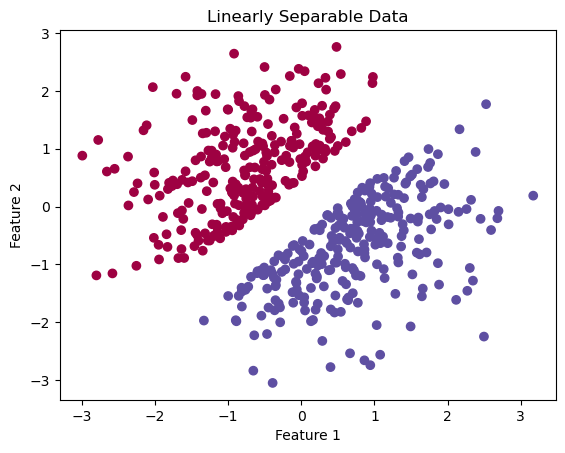

In [2]:
X, Y = generate_line_data()

# Plot the generated data
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linearly Separable Data')
plt.show()

b) Fit a logistic regression model to the data a print out the coefficients.

In [3]:
model = LogisticRegression().fit(X, Y)
model.coef_
model.intercept_

array([0.05839469])

c) Using the coefficients, plot the line through the scatter plot you created in a). (Note: you need to do some math to get the line in the right form)

d) Using the above code, generate and plot the CIRCLE data.

e) Notice that the equation of an ellipse is of the form $$ax^2 + by^2 = c$$

Fit a logistic regression model to an appropriate transformation of X.

In [ ]:
model = ...

f) Plot the decision boundary using the code below.

In [ ]:
# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
meshData = np.c_[xx.ravel(), yy.ravel()]

fig, ax = plt.subplots()
A = model.predict_proba(meshData)[:, 1].reshape(xx.shape)
Z = model.predict(meshData).reshape(xx.shape)
ax.contourf(xx, yy, A, cmap="RdBu", vmin=0, vmax=1)
ax.axis('off')

# Plot also the training points
ax.scatter(X[:, 0], X[:, 1], c=Y, s=50, alpha=0.9)
plt.show()

g) Plot the XOR data. In this 2D space, the data is not linearly separable, but by introducing a new feature $$x_3 = x_1 * x_2$$

(called an interaction term) we should be able to find a hyperplane that separates the data in 3D. Plot this new dataset in 3D.

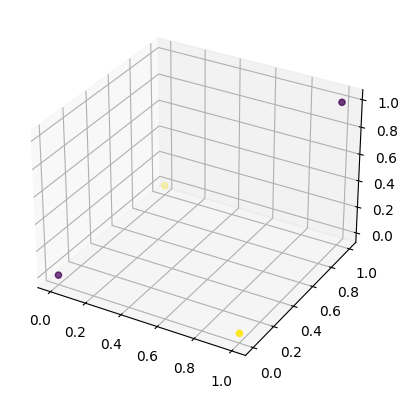

In [3]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = generate_xor_data()
ax = plt.axes(projection='3d')
ax.scatter3D(X[: , 0], X[: , 1], X[: , 0]* X[: , 1], c=Y)
plt.show()

h) Apply a logistic regression model using the interaction term. Plot the decision boundary.

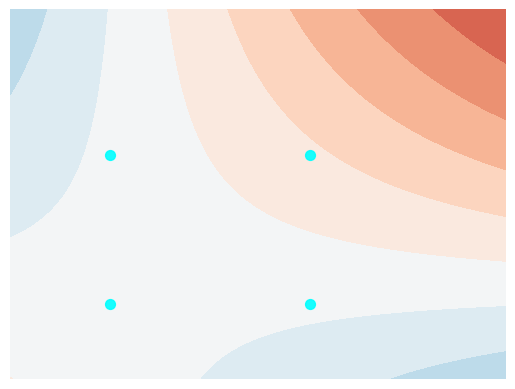

In [4]:
poly = PolynomialFeatures(interaction_only=True)
lr = LogisticRegression(verbose=0)
model = make_pipeline(poly, lr).fit(X, Y)

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
meshData = np.c_[xx.ravel(), yy.ravel()]

fig, ax = plt.subplots()
A = model.predict_proba(meshData)[:, 1].reshape(xx.shape)
Z = model.predict(meshData).reshape(xx.shape)
ax.contourf(xx, yy, A, cmap="RdBu", vmin=0, vmax=1)
ax.axis('off')

# Plot also the training points
ax.scatter(X[:, 0], X[:, 1], color=Y, s=50, alpha=0.9)
plt.show()

In [ ]:
%matplotlib widget
for i in range(20000):
    for solver in ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']:
        X_transform = PolynomialFeatures(interaction_only=True, include_bias=False).fit_transform(X)
        model = LogisticRegression(verbose=0, solver=solver, random_state=i, max_iter=10000)
        model.fit(X_transform, Y)
        print(model.score(X_transform, Y))
        if model.score(X_transform, Y) > .75:
            print("random state = ", i)
            print("solver = ", solver)
            break

print(model.coef_)
print(model.intercept_)

xx, yy = np.meshgrid([x / 10 for x in range(-1, 11)], [x / 10 for x in range(-1, 11)])
z = - model.intercept_ / model.coef_[0][2] - model.coef_[0][0] * xx / model.coef_[0][2] - model.coef_[0][1] * yy / model.coef_[0][2]

ax = plt.axes(projection='3d')
ax.scatter3D(X[: , 0], X[: , 1], X[: , 0]* X[: , 1], c=Y)
ax.plot_surface(xx, yy, z, alpha=0.5)
plt.show()

i) Using the code below that generates 3 concentric circles, fit a logisitc regression model to it and plot the decision boundary.

In [ ]:
t, _ = datasets.make_blobs(n_samples=1500, centers=centers, cluster_std=2,
                                random_state=0)

# CIRCLES
def generate_circles_data(t):
    def label(x):
        if x[0]**2 + x[1]**2 >= 2 and x[0]**2 + x[1]**2 < 8:
            return 1
        if x[0]**2 + x[1]**2 >= 8:
            return 2
        return 0
    # create some space between the classes
    X = np.array(list(filter(lambda x : (x[0]**2 + x[1]**2 < 1.8 or x[0]**2 + x[1]**2 > 2.2) and (x[0]**2 + x[1]**2 < 7.8 or x[0]**2 + x[1]**2 > 8.2), t)))
    Y = np.array([label(x) for x in X])
    return X, Y

X, Y = ...

poly = PolynomialFeatures(2)
lr = LogisticRegression(verbose=2)
model = make_pipeline(poly, lr).fit(X, Y)

...